# Générer des données depuis un fichier source de symuvia

Dans cette note, on présente les méthodes permettant de générer des données diverses à partir de données brutes de trajectoire depuis Symuvia.
Pour voir les méthodes d'extraction des données depuis Symuvia, voir le fichier *ExtraireDonneesSymuvia.ipynb*.
On commence par charger le nécessaire.

In [52]:
# Import the required packages
import tools
import pandas as pd
import random
import numpy as np

# Load the xml file and make a dataset of trajectories
filename = "Init_070000_120000_traf.xml"
df = tools.toDataSet(filename)

# Display the first 5 rows of the dataset
df.head(5)

,id,t,X,Y,vit,tron,dst
0,0,8.0,654340.98,6836174.27,18.0,T_56451886_FRef,1.9
1,0,9.0,654323.16,6836176.78,18.0,T_56451886_FRef,19.9
2,0,10.0,654305.33,6836179.29,18.0,T_56451886_FRef,37.9
3,0,11.0,654287.51,6836181.80,18.0,T_56451886_FRef,55.9
4,0,12.0,654269.69,6836184.31,18.0,T_56451886_FRef,73.9


## Générer des données de véhicules sondes

Pour générer des données de véhicules sondes, on a 3 paramètres :

* Le taux de pénétration ou le taux de véhicules équipé de système de géolocalisation 
* La fréquence de remontée d'information
* Information globale (*Lambert 93* - `global`) ou relative (tronçon+distance - `relative`) ou les deux (`both`)

1 entrée :

* Le DataFrame des trajectoires

On crée ainsi une fonction Python :

In [55]:
def generateProbeData(inputDf, tau, freq, scale = 'both'):
    # On choisit un échantillon de véhicule parmis l'ensemble des véhicules présents
    indices  = random.sample(set(pd.unique(inputDf.id)), int(tau*np.size(pd.unique(inputDf.id))))
    newDf = inputDf[inputDf.id.isin(indices)]
    
    # On supprime les colonnes correspondantes
    if scale == 'global':
        # keep only the global scale columns
        newDf = newDf.loc[:,['id', 't', 'X', 'Y', 'vit']]
    elif scale == 'relative':
        # keep only the relative scale columns
        newDf = newDf.loc[:, ['id', 't', 'tron', 'dst', 'vit']]
    elif scale != 'both':
        # raise an error if the scale argument do not correspond to what it should be
        raise TypeError('the argument \'scale\' has to be one of \'both\', \'global\' or \'relative\' ')
    
    #Frequence de remontée
    for id in pd.unique(newDf.id):
        firstPoint = int(min(newDf[newDf.id==id].t)) + random.randint(0,freq-1)
        times = list(range(firstPoint, int(max(newDf[newDf.id==id].t)), freq))
        # On récupère les lignes correspondantes, on range par t puis id et on réinitialise les index.
        newDf = newDf[(newDf['t'].isin(times)) | (newDf['id'] !=id)].sort_values(by = ['t', 'id']).reset_index(drop=True)
    
        
    return newDf


On affiche les 5 premières lignes d'un appel de la fonction pour des données avec 15% des véhicules équipés et une fréquence de remontée d'information de 1 toutes les 60s.
On veut des données relatives.

In [56]:
generateProbeData(df, tau=0.15, freq=60, scale='relative').head(5)

,id,t,tron,dst,vit
0,10,36.0,T_865037904_FRef,16.98,8.33
1,14,51.0,T_56441638_FRef,189.90,18.00
2,27,74.0,T_68847245_FRef,7.21,18.00
3,28,92.0,T_928015135_FRef,15.15,18.00
4,10,96.0,T_773065988_FRef,115.16,18.00


On affiche la même chose avec un taux de 40% et une remontée toutes les 30s pour une échelle globale.

In [57]:
generateProbeData(df, tau=0.40, freq=30, scale='global').head(5)

,id,t,X,Y,vit
0,7,33.0,645593.35,6836259.32,13.89
1,12,42.0,639834.78,6839291.97,18.00
2,6,46.0,647816.80,6836120.24,18.00
3,4,50.0,650005.31,6836306.70,18.00
4,17,58.0,645726.02,6836289.63,13.89


Pour enregistrer les données en csv, on doit utiliser la fonction [`to_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html)

## Génération de données boucles
La génération de données boucles font appel à plusieurs paramètres :
* Tronçon sur la boucle `tron`
* Emplacement de la boucle sur le tronçon `dst`
* Période d'aggrégation `agg`

On dispose aussi de la dataframe des trajectoires de l'ensemble des véhicules.

### Génération des débits pour une boucle

On crée aussi une fonction Python correspondant à une boucle:

In [66]:
def generateOneLoopData(df, tron, dst, agg):
    # On filtre la dataframe par rapport au tronçon considéré
    df = df[df.tron == tron]
    # Pour faciliter les calculs on recherche une fenêtre de distance
    # cette fenêtre est calculée de façon à ce qu'on aie un point minimum de trajectoire avant et un après la boucle
    # il s'agit de l'emplacement de la boucle - et + la distance parcourue à vitesse max par les véhicules en un pas de temps
    maxSpeed = max(df.vit)
    
    #On génère les données de temps de passage à la boucle
    times = []
    # boucle sur les différents véhicules
    for id in pd.unique(df.id):
        # Interpolation linéaire ?? pour trouver l'instant de passage de la boucle
        times.append(np.interp(dst, df[df.id==id].dst, df[df.id==id].t))
    
    times = np.array(times)
    #Partie aggrégation
    outputTimes = list(np.arange(agg, max(df.t), agg))
    outputFlow = []
    for time in outputTimes:
        outputFlow.append(np.size(times[list(np.where((times < time) & (times > (time - agg)))[0])])/agg)
        
    return (outputTimes, outputFlow)

On illustre le résultat sur un tronçon arbitraire avec une période d'aggrégation de 60s.

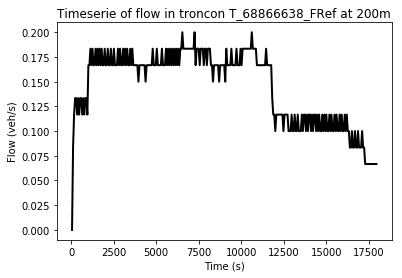

In [67]:
#Generation
times, flows = generateOneLoopData(df, tron = "T_68866638_FRef", dst = 200, agg = 60)
# Tracé
from matplotlib import pyplot as plt
plt.plot(times, flows, linewidth = 2, color = 'black')
plt.xlabel('Time (s)')
plt.ylabel('Flow (veh/s)')
plt.title('Timeserie of flow in troncon T_68866638_FRef at 200m')
plt.show()

### Génération des débits pour plusieurs boucles

On part du principe que les informations des boucles sont comprises dans une dataframe comme suivant :

In [74]:
loopsDF = pd.DataFrame(
        {"id" : ['loop_1','loop_2','loop_3'],
         "tron" : ['T_68866638_FRef','T_727978488_FRef','T_56451886_FRef'],
         "dst" : ['200', '150', '30']})
loopsDF = inputeDF[["id", "tron", "dst"]]
loopsDF

,id,tron,dst
0,loop_1,T_68866638_FRef,200
1,loop_2,T_727978488_FRef,150
2,loop_3,T_56451886_FRef,30


La fonction Python pour la génération des données est la suivante :

In [80]:
def generateLoopData(trajsDf, loopsDf, agg):
    # On créer une nouvelle data frame
    output = pd.DataFrame(columns = ['id', 't', 'flow'])
    # On boucle sur les boucles
    for i in range(len(loopsDf.index)):
        times, flows = generateOneLoopData(trajsDf, tron = loopsDf.iloc[i]['tron'], dst = int(loopsDf.iloc[i]['dst']), agg = agg)
        # Génération de la nouvelle dataFrame
        newDf = pd.DataFrame(
        {"id" : [loopsDf.iloc[i]['id']]*len(times),
         "t" : times,
         "flow" : flows})
        # Concaténation
        output = pd.concat([output,newDf])
        
        output =  output[['id','t','flow']].sort_values(by = 't').reset_index(drop=True)
    return output

In [81]:
generateLoopData(df, loopsDF, 600).head(5)

,id,t,flow
0,loop_1,600.0,0.110000
1,loop_2,600.0,0.066667
2,loop_3,600.0,0.125000
3,loop_1,1200.0,0.143333
4,loop_2,1200.0,0.050000
